# Курсовой проект для курса "Python для Data Science"
## Задание:
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

## Целевая переменная:
Price

## Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

## Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook  с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price). В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

## Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

## Примечания:
Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая.
В файлах не должны содержаться индексы из датафрейма.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

# Импорт данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'jpeg'
%matplotlib inline
pd.options.display.max_columns = 100

In [350]:
data = pd.read_csv('train.csv')
data.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


# One Hot Encoding

Смотрим количество уникальных значений, чтобы мы не разорвались по памяти

In [145]:
print('Ecology_2 unique:', data['Ecology_2'].unique())
print('Ecology_3 unique:', data['Ecology_3'].unique())
print('Shops_2 unique:', data['Shops_2'].unique())

Ecology_2 unique: ['B' 'A']
Ecology_3 unique: ['B' 'A']
Shops_2 unique: ['B' 'A']


In [351]:
def one_hot_encoder(adata):
    return pd.get_dummies(adata, columns=['Ecology_2', 'Ecology_3', 'Shops_2'])
data = one_hot_encoder(data)
data.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063,0,1,0,1,0,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524,0,1,0,1,0,1


# Подготавливаем неправильно вбитые данные
## Swap bigger 'LifeSquare' with 'Square'

In [352]:
def swap_lifesquare_with_square(adata):
    tmp_filter_col = lambda df: (df['LifeSquare'].notna()) & (df['LifeSquare'] > df['Square'])
    adata['tmp_filter_col'] = tmp_filter_col(adata)
    print('Before LifeSquare⇔Square swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.loc[adata['tmp_filter_col'], 'LifeSquare'], adata.loc[adata['tmp_filter_col'], 'Square'] = adata.loc[adata['tmp_filter_col'], 'Square'], adata.loc[adata['tmp_filter_col'], 'LifeSquare']
    print('After LifeSquare⇔Square swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.drop(columns=['tmp_filter_col'], inplace=True)
    return adata
data = swap_lifesquare_with_square(data.copy())

Before LifeSquare⇔Square swap:  482
After LifeSquare⇔Square swap:  0


## Swap bigger 'Floor' with 'HouseFloor'

In [353]:
def swap_floor_with_housefloor(adata):
    tmp_filter_col = lambda df: (df['HouseFloor'] > 0) & (df['Floor'] > df['HouseFloor'])
    adata['tmp_filter_col'] = tmp_filter_col(adata)
    print('Before Floor⇔HouseFloor swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.loc[adata['tmp_filter_col'], 'Floor'], adata.loc[adata['tmp_filter_col'], 'HouseFloor'] = adata.loc[adata['tmp_filter_col'], 'HouseFloor'], adata.loc[adata['tmp_filter_col'], 'Floor']
    print('After Floor⇔HouseFloor swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.drop(columns=['tmp_filter_col'], inplace=True)
    return adata
data = swap_floor_with_housefloor(data.copy())

Before Floor⇔HouseFloor swap:  1556
After Floor⇔HouseFloor swap:  0


In [279]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Корелляция

In [194]:
perceptible_corr = data.corr().where(lambda v: (np.abs(v) > 0.1) & (np.abs(v) < 1))
perceptible_corr

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
Id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DistrictId,NaN,NaN,NaN,NaN,NaN,NaN,-0.133957,-0.149051,NaN,NaN,0.246463,0.167479,0.136095,0.304335,0.306147,0.174214,0.265100,NaN,NaN,NaN,NaN,NaN,NaN
Rooms,NaN,NaN,NaN,0.662893,0.568310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.550291,NaN,NaN,NaN,NaN,NaN,NaN
Square,NaN,NaN,0.662893,NaN,0.811406,NaN,0.126922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.520075,NaN,NaN,NaN,NaN,NaN,NaN
LifeSquare,NaN,NaN,0.568310,0.811406,NaN,NaN,0.102717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.408107,NaN,NaN,NaN,NaN,NaN,NaN
KitchenSquare,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Floor,NaN,-0.133957,NaN,0.126922,0.102717,NaN,NaN,0.498364,NaN,NaN,NaN,NaN,NaN,-0.146383,NaN,NaN,0.110916,NaN,NaN,NaN,NaN,NaN,NaN
HouseFloor,NaN,-0.149051,NaN,NaN,NaN,NaN,0.498364,NaN,NaN,NaN,NaN,NaN,NaN,-0.143973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HouseYear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ecology_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.124068,NaN,NaN,NaN,NaN,0.110725,-0.110725,0.223197,-0.223197,NaN,NaN


Колонки, влияющие на цену

In [195]:
price_corr_columns = perceptible_corr[['Price']].dropna().sort_values('Price', ascending=False)
print(price_corr_columns.index.values)
price_corr_columns

['Rooms' 'Square' 'LifeSquare' 'DistrictId' 'Social_1' 'Helthcare_2'
 'Social_2' 'Shops_1' 'Healthcare_1' 'Floor']


,Price
Rooms,0.550291
Square,0.520075
LifeSquare,0.408107
DistrictId,0.265100
Social_1,0.263286
Helthcare_2,0.253090
Social_2,0.239226
Shops_1,0.180876
Healthcare_1,0.138755
Floor,0.110916


# Выбросы

## 'Rooms' и 'Square'

Исследуем 'Rooms' и 'Square' как самые сильные признаки для Price.

In [196]:
data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

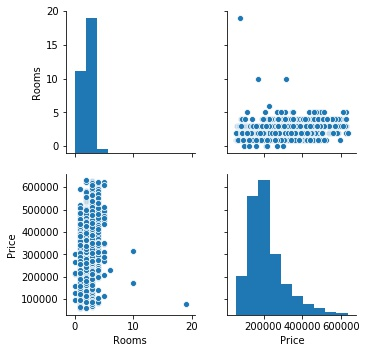

In [197]:
sns.pairplot(data.loc[:, ['Rooms', 'Price']])

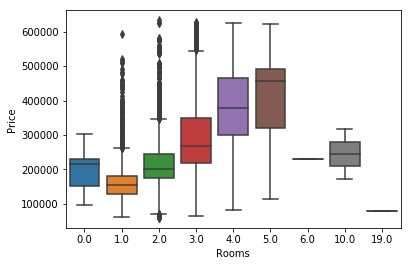

In [198]:
sns.boxplot(data['Rooms'], data['Price'])

Из графиков видно, что самые чистые данные находятся для 1 <= Rooms <= 5 в пределах 1 и 3 квартилей

In [354]:
rooms_quantiles = data.where((data['Rooms'] >= 1) & ((data['Rooms'] <= 5))) \
.groupby('Rooms')[['Price']] \
.quantile(q=[0.25, 0.75], interpolation='nearest')
rooms_quantiles

Price
Rooms                    
1.0   0.25  128711.103732
      0.75  182212.201038
2.0   0.25  174523.257872
      0.75  243479.876105
3.0   0.25  218500.747041
      0.75  349768.675634
4.0   0.25  298885.660186
      0.75  465934.434276
5.0   0.25  310305.074733
      0.75  496026.671162

### Отфильтруем датасет, получив подмножество с идеальным отношением 'Rooms' <-> 'Price'

In [355]:
ideal_rooms_filter = lambda df: (
    ((df['Rooms'] == 1) & (df['Price'] >= 128600) & (df['Price'] <= 182300)) |
    ((df['Rooms'] == 2) & (df['Price'] >= 174400) & (df['Price'] <= 243600)) |
    ((df['Rooms'] == 3) & (df['Price'] >= 218400) & (df['Price'] <= 349900)) |
    ((df['Rooms'] == 4) & (df['Price'] >= 298800) & (df['Price'] <= 466000)) |
    ((df['Rooms'] == 5) & (df['Price'] >= 310200) & (df['Price'] <= 496100))
)
ideal_rooms_data = data.loc[ideal_rooms_filter, ['Id', 'Rooms', 'Square', 'Price']]
print(ideal_rooms_data.count())
ideal_rooms_data['Rooms'].value_counts()

Id        5015
Rooms     5015
Square    5015
Price     5015
dtype: int64


2.0    1946
1.0    1860
3.0    1123
4.0      76
5.0      10
Name: Rooms, dtype: int64

### Фильтруем дальше, чтобы получить подмножество с идеальным отношением 'Rooms' <-> 'Square' <-> 'Price'

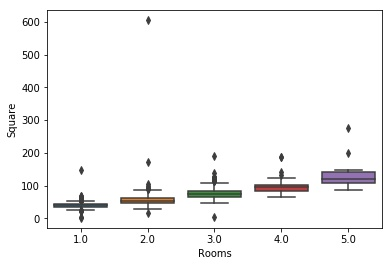

In [207]:
sns.boxplot(ideal_rooms_data['Rooms'], ideal_rooms_data['Square'])

In [358]:
square_quantiles = ideal_rooms_data.groupby('Rooms')[['Square']].quantile(q=[0.25, 0.75], interpolation='nearest')
square_quantiles

Square
Rooms                 
1.0   0.25   35.784271
      0.75   43.192992
2.0   0.25   46.273040
      0.75   63.056315
3.0   0.25   63.898844
      0.75   82.544433
4.0   0.25   82.945530
      0.75  101.978514
5.0   0.25  108.057398
      0.75  147.709302

Id        2948
Rooms     2948
Square    2948
Price     2948
dtype: int64


2.0    1195
1.0    1074
3.0     627
4.0      46
5.0       6
Name: Rooms, dtype: int64

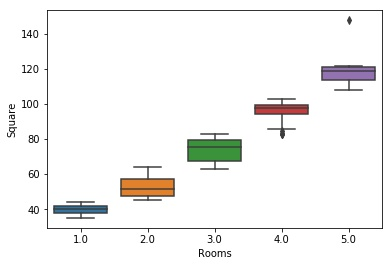

In [359]:
ideal_square_filter = lambda df: (
    ((df['Rooms'] == 1) & (df['Square'] >= 35) & (df['Square'] <= 44)) |
    ((df['Rooms'] == 2) & (df['Square'] >= 45) & (df['Square'] <= 64)) |
    ((df['Rooms'] == 3) & (df['Square'] >= 63) & (df['Square'] <= 83)) |
    ((df['Rooms'] == 4) & (df['Square'] >= 82) & (df['Square'] <= 103))|
    ((df['Rooms'] == 5) & (df['Square'] >= 107) & (df['Square'] <= 149))
)
ideal_square_data = data.loc[ideal_square_filter(data) & ideal_rooms_filter(data), ['Id', 'Rooms', 'Square', 'Price']]
sns.boxplot(ideal_square_data['Rooms'], ideal_square_data['Square'])
print(ideal_square_data.count())
ideal_square_data['Rooms'].value_counts()

In [217]:
ideal_square_data.corr()

,Id,Rooms,Square,Price
Id,1.000000,-0.008586,-0.001131,0.000151
Rooms,-0.008586,1.000000,0.927819,0.888567
Square,-0.001131,0.927819,1.000000,0.847946
Price,0.000151,0.888567,0.847946,1.000000


## Модели

In [360]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


def model_fit(df_features, df_target):
    clf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                       param_grid=[{'n_estimators': [100, 250, 500], 'max_depth': [5, 9, 15, 27]}],
                       cv=5)
    clf.fit(df_features, df_target)
    return clf


def show_model(clf_model):
    print('Лучшие параметры модели:', clf_model.best_params_)
    for mean, std, params in zip(clf_model.cv_results_['mean_test_score'], clf_model.cv_results_['std_test_score'], clf_model.cv_results_['params']):
        print("%0.4f (±%0.4f) for %r" % (mean, std * 2, params))

### Строим модель для фиксов 'Square'

In [361]:
clf_square = model_fit(
    ideal_square_data.loc[:, ideal_square_data.columns.isin(['Rooms', 'Price'])], 
    ideal_square_data.loc[:, ideal_square_data.columns == 'Square'].values.ravel()
)
show_model(clf_square)

Лучшие параметры модели: {'max_depth': 5, 'n_estimators': 500}
0.8814 (±0.0205) for {'max_depth': 5, 'n_estimators': 100}
0.8818 (±0.0198) for {'max_depth': 5, 'n_estimators': 250}
0.8819 (±0.0198) for {'max_depth': 5, 'n_estimators': 500}
0.8753 (±0.0227) for {'max_depth': 9, 'n_estimators': 100}
0.8756 (±0.0221) for {'max_depth': 9, 'n_estimators': 250}
0.8755 (±0.0224) for {'max_depth': 9, 'n_estimators': 500}
0.8575 (±0.0299) for {'max_depth': 15, 'n_estimators': 100}
0.8582 (±0.0295) for {'max_depth': 15, 'n_estimators': 250}
0.8583 (±0.0289) for {'max_depth': 15, 'n_estimators': 500}
0.8363 (±0.0353) for {'max_depth': 27, 'n_estimators': 100}
0.8370 (±0.0351) for {'max_depth': 27, 'n_estimators': 250}
0.8372 (±0.0345) for {'max_depth': 27, 'n_estimators': 500}


### Строим модель для фиксов 'Room'

In [362]:
clf_rooms = model_fit(
    ideal_square_data.loc[:, ideal_square_data.columns.isin(['Square', 'Price'])], 
    ideal_square_data.loc[:, ideal_square_data.columns == 'Rooms'].values.ravel()
)
show_model(clf_rooms)

Лучшие параметры модели: {'max_depth': 15, 'n_estimators': 500}
0.9947 (±0.0021) for {'max_depth': 5, 'n_estimators': 100}
0.9948 (±0.0020) for {'max_depth': 5, 'n_estimators': 250}
0.9948 (±0.0022) for {'max_depth': 5, 'n_estimators': 500}
0.9948 (±0.0033) for {'max_depth': 9, 'n_estimators': 100}
0.9949 (±0.0034) for {'max_depth': 9, 'n_estimators': 250}
0.9949 (±0.0035) for {'max_depth': 9, 'n_estimators': 500}
0.9948 (±0.0033) for {'max_depth': 15, 'n_estimators': 100}
0.9949 (±0.0034) for {'max_depth': 15, 'n_estimators': 250}
0.9949 (±0.0035) for {'max_depth': 15, 'n_estimators': 500}
0.9948 (±0.0033) for {'max_depth': 27, 'n_estimators': 100}
0.9949 (±0.0034) for {'max_depth': 27, 'n_estimators': 250}
0.9949 (±0.0035) for {'max_depth': 27, 'n_estimators': 500}


### Исправляем 'Square' и 'Rooms' в данных

In [367]:
def fix_square(adata, filter_square, filter_rooms, model_square):
    print('Корелляция Square⇔Price до фиксов', adata.corr()['Square']['Price'])
    data_filter = lambda d: ~(filter_square(d) & filter_rooms(d))
    adata.loc[lambda d: data_filter(d), 'Square'] = model_square.predict(adata.loc[lambda d: data_filter(d), ['Rooms', 'Price']])
    print('Корелляция Square⇔Price после фиксов', adata.corr()['Square']['Price'])
    return adata
data = fix_square(data.copy(), ideal_square_filter, ideal_rooms_filter, clf_square)

Корелляция Square⇔Price до фиксов 0.5783736427316061
Корелляция Square⇔Price после фиксов 0.779046628563952


In [368]:
def fix_rooms(adata, filter_square, filter_rooms, model_rooms):
    print('Корелляция Rooms⇔Price до фиксов', adata.corr()['Rooms']['Price'])
    data_filter = lambda d: ~(filter_square(d) & filter_rooms(d))
    adata.loc[lambda d: data_filter(d), 'Rooms'] = model_rooms.predict(adata.loc[lambda d: data_filter(d), ['Square', 'Price']])
    print('Корелляция Rooms⇔Price после фиксов', adata.corr()['Rooms']['Price'])
    return adata
data = fix_rooms(data.copy(), ideal_square_filter, ideal_rooms_filter, clf_rooms)

Корелляция Rooms⇔Price до фиксов 0.7417425668048085
Корелляция Rooms⇔Price после фиксов 0.7848302637342064


## 'LifeSquare'

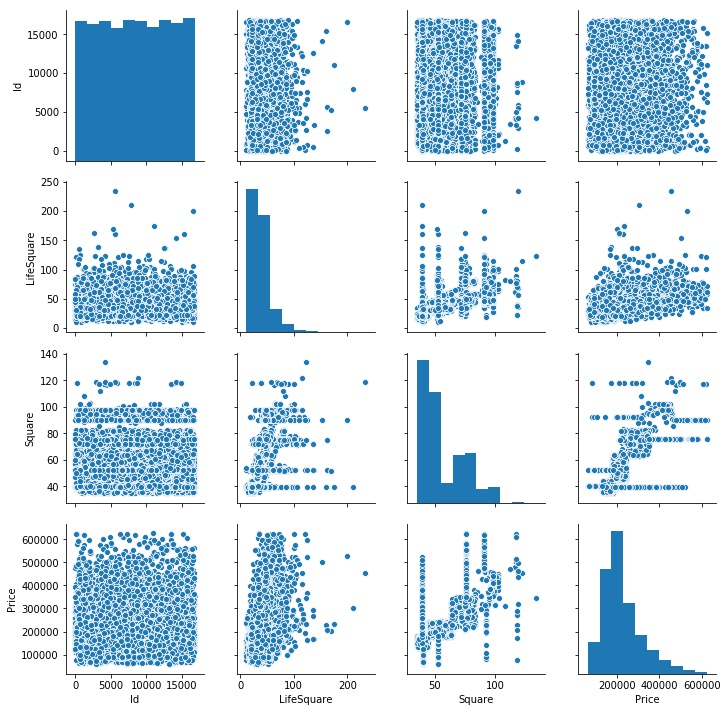

In [369]:
filter_ideal_lifesquare = lambda df: (
    (df['LifeSquare'].notna()) & 
    (df['LifeSquare'] < 400) & 
    (df['Square'] < 400) & 
    (df['LifeSquare'] > 10)
)
ideal_lifesquare_sample = data.loc[lambda df: filter_ideal_lifesquare(df), ['Id', 'LifeSquare', 'Square', 'Price']]
sns.pairplot(ideal_lifesquare_sample)

In [370]:
clf_lifesquare = model_fit(
    ideal_lifesquare_sample.loc[:, ideal_lifesquare_sample.columns.isin(['Square', 'Price'])], 
    ideal_lifesquare_sample.loc[:, ideal_lifesquare_sample.columns == 'LifeSquare'].values.ravel()
)
show_model(clf_lifesquare)

Лучшие параметры модели: {'max_depth': 5, 'n_estimators': 500}
0.3752 (±0.0832) for {'max_depth': 5, 'n_estimators': 100}
0.3766 (±0.0821) for {'max_depth': 5, 'n_estimators': 250}
0.3770 (±0.0824) for {'max_depth': 5, 'n_estimators': 500}
0.3498 (±0.0908) for {'max_depth': 9, 'n_estimators': 100}
0.3507 (±0.0908) for {'max_depth': 9, 'n_estimators': 250}
0.3512 (±0.0910) for {'max_depth': 9, 'n_estimators': 500}
0.2729 (±0.1098) for {'max_depth': 15, 'n_estimators': 100}
0.2740 (±0.1107) for {'max_depth': 15, 'n_estimators': 250}
0.2746 (±0.1103) for {'max_depth': 15, 'n_estimators': 500}
0.1822 (±0.1131) for {'max_depth': 27, 'n_estimators': 100}
0.1831 (±0.1142) for {'max_depth': 27, 'n_estimators': 250}
0.1836 (±0.1155) for {'max_depth': 27, 'n_estimators': 500}


In [371]:
def fix_lifesquare(adata, filter_lifesquare, model_lifesquare):
    print('Корелляция LifeSquare⇔Price, LifeSquare⇔Square до фиксов', adata.corr()['LifeSquare']['Price'], adata.corr()['LifeSquare']['Square'])
    adata.loc[lambda df: ~filter_lifesquare(df), 'LifeSquare'] = model_lifesquare.predict(adata.loc[lambda df: ~filter_lifesquare(df), ['Square', 'Price']])
    print('Корелляция LifeSquare⇔Price, LifeSquare⇔Square после фиксов', adata.corr()['LifeSquare']['Price'], adata.corr()['LifeSquare']['Square'])
    return adata
data = fix_lifesquare(data.copy(), filter_ideal_lifesquare, clf_lifesquare)

Корелляция LifeSquare⇔Price, LifeSquare⇔Square до фиксов 0.36356966846690975 0.489248680953381
Корелляция LifeSquare⇔Price, LifeSquare⇔Square после фиксов 0.43013927573088184 0.5935053451404874


## 'Floor', 'HouseFloor', 'HouseYear'

In [381]:
data.loc[:, ['Floor', 'HouseFloor', 'HouseYear']].describe()

,Floor,HouseFloor,HouseYear
count,10000.000000,10000.000000,1.000000e+04
mean,7.943200,13.623800,3.990166e+03
std,5.228127,5.794811,2.005003e+05
min,1.000000,1.000000,1.910000e+03
25%,4.000000,9.000000,1.974000e+03
50%,7.000000,14.000000,1.977000e+03
75%,11.000000,17.000000,2.001000e+03
max,42.000000,48.000000,2.005201e+07


In [382]:
invalid_hy_filter = ((ideal_yr['HouseYear'] < 1900) | (ideal_yr['HouseYear'] > 2030))
data.loc[invalid_hy_filter, 'HouseYear'] = data['HouseYear'].median()
data.loc[:, ['HouseYear']].describe()

,HouseYear
count,1.000000e+04
mean,3.990166e+03
std,2.005003e+05
min,1.910000e+03
25%,1.974000e+03
50%,1.977000e+03
75%,2.001000e+03
max,2.005201e+07


In [383]:
hf_basedon_year = data.groupby('HouseYear')['HouseFloor'].median()
hf_basedon_year.values

array([ 9. ,  8. ,  8. ,  6. ,  6. ,  5. ,  5. ,  5. ,  7. ,  6. ,  5. ,
        5. ,  6. ,  5. ,  7. ,  6. ,  5. ,  8. ,  6.5,  7. ,  7.5,  5. ,
        8. ,  9. ,  5. ,  6. ,  5. ,  5. ,  6. ,  6. ,  8. ,  6. ,  5. ,
        5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  6. ,  7. ,  9. ,  9. ,  9. ,
        9. ,  9. ,  9. ,  9. , 10. , 12. , 12. , 17. , 12. , 12. , 12. ,
       12. , 12. , 14. , 16. , 16. , 17. , 17. , 17. , 17. , 17. , 17. ,
       17. , 17. , 17. , 14.5, 14. , 14. , 14. , 17. , 17. , 17. , 17. ,
       17. , 17. , 17. , 17. , 17. , 17. , 17. , 17. , 17. , 19. , 17. ,
       17. , 17. , 17. , 17. , 17. , 17. , 22. ,  9. , 12. ])

In [384]:
invalid_hf_filter = lambda df: ((df['HouseFloor'] == 0) | (df['HouseFloor'] > 50))
fixed_hf = data.loc[invalid_hf_filter, 'HouseYear'].map(hf_basedon_year.get)
data.loc[invalid_hf_filter, 'HouseFloor'] = fixed_hf
data.loc[:, ['Floor', 'HouseFloor', 'HouseYear']].describe()

,Floor,HouseYear
count,10000.000000,1.000000e+04
mean,7.943200,3.990166e+03
std,5.228127,2.005003e+05
min,1.000000,1.910000e+03
25%,4.000000,1.974000e+03
50%,7.000000,1.977000e+03
75%,11.000000,2.001000e+03
max,42.000000,2.005201e+07


In [385]:
print('Корреляция до:')
perceptible_corr.loc[:, ['HouseFloor']].dropna(how='all')

Корреляция до:


,HouseFloor
DistrictId,-0.149051
Floor,0.498364
Healthcare_1,-0.143973


In [387]:
print('Корреляция после:')
data.corr().where((np.abs(ideal_hf_corr) > 0.1) & (np.abs(ideal_hf_corr) < 1)).loc[:, ['HouseFloor']].dropna(how='all')

Корреляция после:


KeyError: "None of [Index(['HouseFloor'], dtype='object')] are in the [columns]"

## Healthcare_1

In [72]:
healthcare_corr = data_final.loc[data_final['Healthcare_1'].notnull(), :].corr().loc[lambda df: (np.abs(df['Healthcare_1']) > 0.1) & (np.abs(df['Healthcare_1']) < 1), ['Healthcare_1']]
healthcare_corr

,Healthcare_1
DistrictId,0.304335
Floor,-0.112202
HouseFloor,-0.191400
HouseYear,-0.205125
Social_3,0.133877
Helthcare_2,0.203177
Price,0.138755
Ecology_3_A,0.114715
Ecology_3_B,-0.114715


In [227]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
train_set = data_final.loc[data_final['Healthcare_1'].notnull(), :]
clf_healthcare = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                          param_grid=[{'n_estimators': [200, 250, 300], 'max_depth': [3, 5, 7, 9]}],
                          cv=5)
clf_healthcare.fit(
    train_set.loc[:, train_set.columns.isin(healthcare_corr.index.values)], 
    train_set.loc[:, train_set.columns == 'Healthcare_1'].values.ravel(), 
)
clf_healthcare.best_params_

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [88]:
for mean, std, params in zip(clf_healthcare.cv_results_['mean_test_score'], clf_healthcare.cv_results_['std_test_score'], clf_healthcare.cv_results_['params']):
    print("%0.4f (±%0.4f) for %r" % (mean, std * 2, params))

0.3570 (±0.0407) for {'max_depth': 3, 'n_estimators': 200}
0.3565 (±0.0416) for {'max_depth': 3, 'n_estimators': 250}
0.3573 (±0.0417) for {'max_depth': 3, 'n_estimators': 300}
0.6279 (±0.0416) for {'max_depth': 5, 'n_estimators': 200}
0.6283 (±0.0424) for {'max_depth': 5, 'n_estimators': 250}
0.6279 (±0.0440) for {'max_depth': 5, 'n_estimators': 300}
0.8360 (±0.0288) for {'max_depth': 7, 'n_estimators': 200}
0.8366 (±0.0287) for {'max_depth': 7, 'n_estimators': 250}
0.8361 (±0.0291) for {'max_depth': 7, 'n_estimators': 300}
0.9353 (±0.0168) for {'max_depth': 9, 'n_estimators': 200}
0.9358 (±0.0164) for {'max_depth': 9, 'n_estimators': 250}
0.9355 (±0.0161) for {'max_depth': 9, 'n_estimators': 300}


In [89]:
data_final.loc[data_final['Healthcare_1'].isnull(), 'Healthcare_1'] = clf_healthcare.predict(data_final.loc[data_final['Healthcare_1'].isnull(), healthcare_corr.index.values])

# Собираем итоговый датафрейм

In [389]:
def preprocessData(df, 
                   filter_square,      model_square,
                   filter_rooms,       model_rooms,
                   filter_lifesquare,  model_lifesquare,
                   filter_house_floor, df_house_floor_by_year,
                   filter_house_year
                  ):
    # 'Ecology_2', 'Ecology_3', 'Shops_2'
    df = one_hot_encoder(df)
    # подготавливаем 'LifeSquare', 'Square'
    df = swap_lifesquare_with_square(df.copy())
    # подготавливаем 'Floor', 'HouseFloor'
    df = swap_floor_with_housefloor(df.copy())
    # исправляем Square
    df = fix_square(df.copy(), filter_square, filter_rooms, model_square)
    # исправляем Rooms
    df = fix_rooms(df.copy(), filter_square, filter_rooms, model_rooms)
    # исправляем LifeSquare
    df = fix_lifesquare(df.copy(), filter_lifesquare, model_lifesquare)
    # исправляем HouseYear
    df.loc[filter_house_year, 'HouseYear'] = df['HouseYear'].median()
    # исправляем HouseFloor
    df.loc[filter_house_floor, 'HouseFloor'] = df.loc[filter_house_floor, 'HouseYear'].map(df_house_floor_by_year.get)
    # исправляем Healthcare_1
    df['Healthcare_1'] = df['Healthcare_1'].fillna(-999)
    return df

data_final = preprocessData(pd.read_csv('train.csv'),
                            ideal_square_filter, clf_square,
                            ideal_rooms_filter, clf_rooms,
                            filter_ideal_lifesquare, clf_lifesquare,
                            invalid_hf_filter, hf_basedon_year,
                            invalid_hy_filter
                           )

Before LifeSquare⇔Square swap:  482
After LifeSquare⇔Square swap:  0
Before Floor⇔HouseFloor swap:  1556
After Floor⇔HouseFloor swap:  0
Корелляция Square⇔Price до фиксов 0.14249926312014716
Корелляция Square⇔Price после фиксов 0.5783736427316061
Корелляция Rooms⇔Price до фиксов 0.5502907269258719
Корелляция Rooms⇔Price после фиксов 0.7417425668048085
Корелляция LifeSquare⇔Price, LifeSquare⇔Square до фиксов 0.36356966846690975 0.5556570397906079
Корелляция LifeSquare⇔Price, LifeSquare⇔Square после фиксов 0.34750373443908267 0.6577067160788733


# Масштабируем признаки

In [390]:
from sklearn.preprocessing import StandardScaler
train_columns = data_final.columns.copy().drop(['Id', 'Price'])
df_train = data_final.loc[:, train_columns]
df_test = data_final.loc[:, data_final.columns == 'Price']

scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train)
df_train_scaled = pd.DataFrame(df_train_scaled, columns=train_columns)
df_train_scaled.head(3)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,-0.353348,0.001554,-0.396954,-0.465059,-0.009569,-0.180418,-0.797961,-0.010081,-0.250529,0.474169,0.654880,-0.127533,-0.857652,-0.883480,1.408356,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864
1,-0.215687,1.089394,0.818617,0.133584,0.060460,-0.180418,-0.797961,-0.010036,-0.998053,1.215681,1.237169,-0.295384,0.096048,-0.213923,2.448700,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864
2,0.059635,0.001554,-0.096328,-0.478895,-0.219657,0.010865,-0.280230,-0.010086,-0.581588,0.531208,0.600720,-0.337347,0.087581,-0.213923,-0.256195,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864


# Предсказание
Наблюдаем за изменением главной метрики

In [391]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
x_train, x_test, y_train, y_test = train_test_split(
    df_train_scaled, 
    df_test, 
    test_size=0.25, 
    random_state=42
)

In [392]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Начальное значение:', 0.45173783173008786)
r2_score(y_test, y_pred)

Начальное значение: 0.45173783173008786


0.632579980983527

In [393]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=42, max_depth=9)
dtr.fit(x_train, y_train)
y_pred = dtr.predict(x_test)
print('Начальное значение:', 0.6353812140583176)
r2_score(y_test, y_pred)

Начальное значение: 0.6353812140583176


0.8918257719091426

In [394]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
clf_final = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42), 
    param_grid=[{'n_estimators': [500], 
                 'max_depth': [27],
                 'max_features': [15]}],
    cv=5
)
clf_final.fit(df_train_scaled, df_test.values.ravel())
clf_final.best_params_

{'max_depth': 27, 'max_features': 15, 'n_estimators': 500}

In [395]:
for mean, std, params in zip(clf_final.cv_results_['mean_test_score'], clf_final.cv_results_['std_test_score'], clf_final.cv_results_['params']):
    print("%0.4f (±%0.4f) for %r" % (mean, std * 2, params))

0.9310 (±0.0124) for {'max_depth': 27, 'max_features': 15, 'n_estimators': 500}
